# 특정 키워드로 word2Vec 단어 유사도 보기


## Word2Vec(Word Embedding to Vector)


word2vec은 CBOW 방식과 Skip-Gram 방식의 단어 임베딩을 구현한 C++ 라이브러리로 구글에 있던 Mikolov 등이 개발하였습니다. 파이썬에서는 gensim이라는 패키지에 Word2Vec이라는 클래스로 구현되어 있습니다.

* Radim Řehůřek  : https://twitter.com/radimrehurek/status/630729009500848128


### 컴퓨터는 숫자만 인식할 수 있고 한글, 이미지는 바이너리 코드로 저장 됩니다.

* one hot encoding(예 [0000001000]) 혹은 Bag of Word에서 vector size가 매우 크고 sparse 하므로 neural net 성능이 잘 나오지 않습니다.
* `주위 단어가 비슷하면 해당 단어의 의미는 유사하다` 라는 아이디어
* 단어를 트레이닝 시킬 때 주위 단어를 label로 매치하여 최적화
* 단어를 `의미를 내포한 dense vector`로 매칭 시키는 것

* Word2Vec은 분산 된 텍스트 표현을 사용하여 개념 간 유사성을 봅니다. 
* 예를 들어, 파리와 프랑스가 베를린과 독일이 (수도와 나라) 같은 방식으로 관련되어 있음을 이해합니다.

![word2vec](https://1.bp.blogspot.com/-Q7F8ulD6fC0/UgvnVCSGmXI/AAAAAAAAAbg/MCWLTYBufhs/s1600/image00.gif)
이미지 출처 : https://opensource.googleblog.com/2013/08/learning-meaning-behind-words.html

* 단어의 임베딩과정을 실시간으로 시각화 : [word embedding visual inspector](https://ronxin.github.io/wevi/)


![CBOW와 Skip-Gram](https://i.imgur.com/yXY1LxV.png)
출처 : https://arxiv.org/pdf/1301.3781.pdf
 Tomas Mikolov, Ilya Sutskever, Kai Chen, Greg Corrado, and Jeffrey Dean. Distributed Representations of Words and Phrases and their Compositionality. In Proceedings of NIPS, 2013.


* CBOW와 Skip-Gram기법이 있다.

    * CBOW(continuous bag-of-words)는 전체 텍스트로 하나의 단어를 예측하기 때문에 작은 데이터셋일 수록 유리하다.    
    * 아래 예제에서 __ 에 들어갈 단어를 예측한다.
<pre>
1) __가 맛있다. 
2) __를 타는 것이 재미있다. 
3) 평소보다 두 __로 많이 먹어서 __가 아프다.
</pre>

    * Skip-Gram은 타겟 단어들로부터 원본 단어를 역으로 예측하는 것이다. CBOW와는 반대로 컨텍스트-타겟 쌍을 새로운 발견으로 처리하고 큰 규모의 데이터셋을 가질 때 유리하다.
    * `배`라는 단어 주변에 올 수 있는 단어를 예측한다.
    
    <pre>
    1) *배*가 맛있다. 
    2) *배*를 타는 것이 재미있다. 
    3) 평소보다 두 *배*로 많이 먹어서 *배*가 아프다.
    </pre>



## Word2Vec 참고자료
* [word2vec 모델 · 텐서플로우 문서 한글 번역본](https://tensorflowkorea.gitbooks.io/tensorflow-kr/g3doc/tutorials/word2vec/)
* [Word2Vec으로 문장 분류하기 · ratsgo's blog](https://ratsgo.github.io/natural%20language%20processing/2017/03/08/word2vec/)
* [CS224n: Natural Language Processing with Deep Learning](http://web.stanford.edu/class/cs224n/syllabus.html)
* [Word2Vec Tutorial - The Skip-Gram Model · Chris McCormick](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/)

### 논문
* [Efficient Estimation of Word Representations in
Vector Space](https://arxiv.org/pdf/1301.3781v3.pdf)
* [Distributed Representations of Words and Phrases and their Compositionality](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf)

## Gensim

* [gensim: models.word2vec – Deep learning with word2vec](https://radimrehurek.com/gensim/models/word2vec.html)
* [gensim: Tutorials](https://radimrehurek.com/gensim/tutorial.html)
* [한국어와 NLTK, Gensim의 만남 - PyCon Korea 2015](https://www.lucypark.kr/docs/2015-pyconkr/)


In [1]:
# !pip install soynlp
# !pip show soynlp

In [2]:
# !pip install gensim
# !pip show gensim

In [3]:
import pandas as pd
import numpy as np
import re

<AxesSubplot:title={'center':'한글'}>

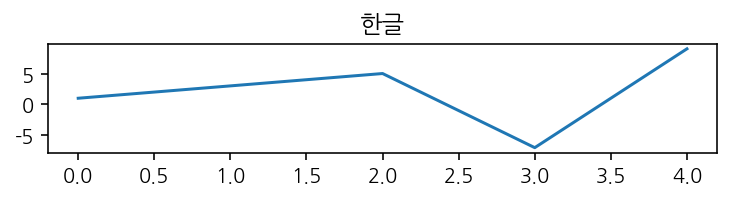

In [54]:
import koreanize_matplotlib

# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'

pd.Series([1, 3, 5, -7, 9]).plot(title="한글", figsize=(6, 1))

# 데이터 로드하기
*  데이터 출처 : https://github.com/akngs/petitions

In [5]:
import os
import platform

base_path = "data"
file_name = "petition.csv"
url ='https://drive.google.com/open?id=1d8VEAj6n83wT1YRlCrhoU_1mMSvYpXc4'

def file_exist_check(base_path, file_name):
    if os.path.exists(f"./{file_name}"):
        print(f"{os.getcwd()}/{base_path} 경로에 파일이 있음")
        return

    if not os.path.exists(base_path):
        os.makedirs(base_path)

    if platform.system() == "Linux":
        # 구글 드라이브에서 csv 파일을 읽어오기 위해 gauth 인증하기
        !pip install -U -q PyDrive
        from pydrive.auth import GoogleAuth
        from pydrive.drive import GoogleDrive
        from google.colab import auth
        from oauth2client.client import GoogleCredentials
        
        auth.authenticate_user()
        gauth = GoogleAuth()
        gauth.credentials = GoogleCredentials.get_application_default()
        drive = GoogleDrive(gauth)

        id = url.split('=')[1]
        downloaded = drive.CreateFile({'id':id}) 
        downloaded.GetContentFile(f'{base_path}/{file_name}')  
        print(f"사용자의 구글 드라이브에 {base_path}/{file_name} 다운로드 완료")
    else:
        print(f"{url} 에서 다운로드 받아 실습 경로 {os.getcwd()}/{base_path}에 옮겨주세요.""")
        return
    
file_exist_check(base_path, file_name) 

https://drive.google.com/open?id=1d8VEAj6n83wT1YRlCrhoU_1mMSvYpXc4 에서 다운로드 받아 실습 경로 /Users/corazzon/codes/pytextbook/data에 옮겨주세요.


In [6]:
df = pd.read_csv(f"{base_path}/petition.csv", index_col="article_id",
                        parse_dates=['start', 'end'])
# 데이터의 크기가 어느정도인지 본다.
df.shape

(377756, 7)

In [7]:
# 관심사별로 텍스트 데이터를 학습시키기 위한 목적도 있지만 전체 텍스트를 돌렸을 때 빠르게 결과를 얻기 위해서 샘플링 하려는 의도도 있습니다.
p = r'.*(P2P|은행|금융|주식|증권|공매도).*'
finance = df[df['title'].str.match(p) |
           df['content'].str.match(p, flags=re.MULTILINE)]
finance.shape

(19866, 7)

In [8]:
finance.head()

,start,end,answered,votes,category,title,content
article_id,,,,,,,
28,2017-08-19,2017-08-26,0,2137,경제민주화,소액주주를 보호해주십시오,** 존경하옵는 문재인대통령님께\n저는 중국원양자원이라는 KOSPI상장사의 소액 ...
32,2017-08-19,2017-09-03,0,30,경제민주화,소액주주 보호를 위해 조사요청 드립니다.,"존경하는 대통령님께,\n코스피 주식종목 중국 원양자원은 현재 계속되는 장** 대표이..."
77,2017-08-20,2017-09-04,0,53,교통/건축/국토,"안양시청, 안양지청, 재개발조합 적폐가 심해 수사가 안되고 있습니다. 안양시 지장물...","※지장물관련 국토부의 해석 : 기존 건축물의 철거 공사에 관한 사항의 범위는 전기,..."
91,2017-08-20,2017-09-19,0,165,경제민주화,증권 자본시장개정안(상장폐지법 개정안),존경하는 문제인 대통령님께\n먼저 어렵고 힘든 국정운영을 이끄시느라 노고가 많으십니...
124,2017-08-20,2017-08-27,0,1,기타,포스코 관련,안녕하십니까?\n최근 뉴스에 주목을 못 받는 뉴스가 있습니다. 아시아경제tv의 포스...


In [9]:
finance.tail()

,start,end,answered,votes,category,title,content
article_id,,,,,,,
491848,2019-01-09,2019-02-08,0,5,기타,은행 업무시간 연장 및 추가 인원 고용,은행 업무 시간을 오후 9시까지 연장해 직장인들도 편리하게 이용할 수 있도록 제안합...
491885,2019-01-09,2019-02-08,0,5,정치개혁,국민연금폐지 하지않으면삶이피폐해진다,35년이 지나면 월급의 30%정도를. 국민연금보험료로 내야합니다.\n계산해보세요\n...
491918,2019-01-09,2019-02-08,0,23,경제민주화,문정부 공매도폐지하라,개미들 돈털어가는 역적 문재인 공매도세력\n모두들 한국 증시 살리기위해 공매도 폐지...
491935,2019-01-09,2019-02-08,0,11,육아/교육,베트남 유학생들에게 10개월째 학비를 돌려주지 않는 서울 ‘**대학’,안녕하세요. 여기는 베트남의 수도 하노이입니다. 최근의 이곳 상황은 베트남 축구대표...
491998,2019-01-09,2019-02-08,0,1,기타,진실은 뉴스가 아니라 마음과 행동입니다,부동산\n새해 복 많이 받으세요\n정말 고생 하시고 수고 많으세요\n전 부동산 개발...


In [10]:
# 샘플로 보고 싶은 인덱스의 번호
sample_index = 28

In [11]:
sample_title = finance['title'][sample_index]
sample_title

'소액주주를 보호해주십시오'

In [12]:
sample_content = finance['content'][sample_index]
sample_content

'**  존경하옵는 문재인대통령님께\\n저는 중국원양자원이라는 KOSPI상장사의 소액 주주입니다. 중국원양자원(이하 중원)은 이번 재회계감사에서 의견거절이라는 감사인 판단이 내려져 꿈에도 생각못한 상장폐지를 목전에 두고 있습니다.\\n상장폐지가되면 국내에 상장하여 천문학적인 금액을 취득하여 회사의 규모를 키우고 개인자산을 불린 후 자신의 지분도  다 팔아서 이득을 챙긴 중국인 장화리 사장은 정리매매때 휴지조각의 비용으로 자신의 지분을 다시 사들이고 대주주로서의 지위를 다시 획득하여 온전히 자신의 기업으로 만들수 있습니다.\\n결국 한국 국민들의 피땀어린 투자금으로 중국인 사장의 부를 채워주지만 이에 대해 한국의 금융당국 및 상장과 운영의 주체인 거래소는 누구도 이에대한 책임없이 이를 그냥 덮어버리고만 말것입니다.\\n이로인해 약 2만 5천의 국내소액주주는 피눈물을 흘리며 고통속에 살게 될 것입니다.\\n주식투자는 개인의 판단하에 이루어지는 것이나 투자에 대한 개인의 책임을 묻기전에 그 과정은 규정과 상식에 맞게 공정하고 정의로워야 할 것입니다. 이는 존경하는 문대통령님의 말씀이라 가슴깊이 새기고 있었으나 현재 우리나라의 금융 시스템, 특히 거래소와 회계감사는 그렇지 못한 것 같습니다.\\n이렇게 생각하게된 이유는 이번 회계감사의 주된 의견거절의 이유 때문입니다\\n이번 신한회계법인의 추측적이고 터무니없는 의견거절로 전재산이 한순간에 물거품으로 사라질 위기에 처한 본인을 비롯한 많은 사람들이 죽음이라는 극단적인 선택앞에 내몰려져 억울함과 원통함에 피눈물을 흘리고 있습니다. .\\n기업의 사업성이나 계속 존속여부를 점검하는 감사자인 회계법인은 오직 밝혀진 사실과 그에 따른 증거만을 근거로 공정하게 기업의 존속여부에 대한 의견을 내야하고 유추할 경우에도 당연히 관련 법이나 판례에 근거하여야 합니다.\\n그러나 신한회계법인은 법또는 제도권으로 확정되지 않은 추정사항을 의견거절의\'결정적 이유\'로 명시하였는바 이는 감사자의 \'의견거절\'에 따른 참혹한 결과로 볼때 

# 텍스트 데이터 전처리 

In [13]:
def preprocessing(text):
    # 개행문자 제거
    text = re.sub('\\\\n', ' ', text)
    # 특수문자 제거
    # 특수문자나 이모티콘 등은 때로는 의미를 갖기도 하지만 여기에서는 제거
    # text = re.sub('[?.,;:|\)*~`’!^\-_+<>@\#$%&-=#}※]', '', text)
    # 한글, 영문, 숫자만 남기고 모두 제거
    # text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z0-9]', ' ', text)
    # 한글, 영문만 남기고 모두 제거
    text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z]', ' ', text)
    return text

In [14]:
sample_content = preprocessing(sample_content)
sample_content[:1000]

'    존경하옵는 문재인대통령님께 저는 중국원양자원이라는 KOSPI상장사의 소액 주주입니다  중국원양자원 이하 중원 은 이번 재회계감사에서 의견거절이라는 감사인 판단이 내려져 꿈에도 생각못한 상장폐지를 목전에 두고 있습니다  상장폐지가되면 국내에 상장하여 천문학적인 금액을 취득하여 회사의 규모를 키우고 개인자산을 불린 후 자신의 지분도  다 팔아서 이득을 챙긴 중국인 장화리 사장은 정리매매때 휴지조각의 비용으로 자신의 지분을 다시 사들이고 대주주로서의 지위를 다시 획득하여 온전히 자신의 기업으로 만들수 있습니다  결국 한국 국민들의 피땀어린 투자금으로 중국인 사장의 부를 채워주지만 이에 대해 한국의 금융당국 및 상장과 운영의 주체인 거래소는 누구도 이에대한 책임없이 이를 그냥 덮어버리고만 말것입니다  이로인해 약  만  천의 국내소액주주는 피눈물을 흘리며 고통속에 살게 될 것입니다  주식투자는 개인의 판단하에 이루어지는 것이나 투자에 대한 개인의 책임을 묻기전에 그 과정은 규정과 상식에 맞게 공정하고 정의로워야 할 것입니다  이는 존경하는 문대통령님의 말씀이라 가슴깊이 새기고 있었으나 현재 우리나라의 금융 시스템  특히 거래소와 회계감사는 그렇지 못한 것 같습니다  이렇게 생각하게된 이유는 이번 회계감사의 주된 의견거절의 이유 때문입니다 이번 신한회계법인의 추측적이고 터무니없는 의견거절로 전재산이 한순간에 물거품으로 사라질 위기에 처한 본인을 비롯한 많은 사람들이 죽음이라는 극단적인 선택앞에 내몰려져 억울함과 원통함에 피눈물을 흘리고 있습니다    기업의 사업성이나 계속 존속여부를 점검하는 감사자인 회계법인은 오직 밝혀진 사실과 그에 따른 증거만을 근거로 공정하게 기업의 존속여부에 대한 의견을 내야하고 유추할 경우에도 당연히 관련 법이나 판례에 근거하여야 합니다  그러나 신한회계법인은 법또는 제도권으로 확정되지 않은 추정사항을 의견거절의 결정적 이유 로 명시하였는바 이는 감사자의  의견거절 에 따른 참혹한 결과로 볼때      명의 국민들과 그 가족들은 공정

In [15]:
# %time을 찍어주면 해당 코드를 실행할 때 걸리는 시간을 출력
%time sentences = finance['content'].apply(preprocessing)

CPU times: user 1.12 s, sys: 16.5 ms, total: 1.14 s
Wall time: 1.14 s


# soynlp를 사용해 토큰화

## 텍스트 데이터 전처리 이해하기

(출처 : [트위터 한국어 형태소 분석기](https://github.com/twitter/twitter-korean-text))

**정규화 normalization (입니닼ㅋㅋ -> 입니다 ㅋㅋ, 샤릉해 -> 사랑해)**

* 한국어를 처리하는 예시입니닼ㅋㅋㅋㅋㅋ -> 한국어를 처리하는 예시입니다 ㅋㅋ

**토큰화 tokenization**

* 한국어를 처리하는 예시입니다 ㅋㅋ -> 한국어Noun, 를Josa, 처리Noun, 하는Verb, 예시Noun, 입Adjective, 니다Eomi ㅋㅋKoreanParticle

**어근화 stemming (입니다 -> 이다)**

* 한국어를 처리하는 예시입니다 ㅋㅋ -> 한국어Noun, 를Josa, 처리Noun, 하다Verb, 예시Noun, 이다Adjective, ㅋㅋKoreanParticle


**어구 추출 phrase extraction** 

* 한국어를 처리하는 예시입니다 ㅋㅋ -> 한국어, 처리, 예시, 처리하는 예시

Introductory Presentation: [Google Slides](https://docs.google.com/presentation/d/10CZj8ry03oCk_Jqw879HFELzOLjJZ0EOi4KJbtRSIeU/)

In [16]:
from soynlp.tokenizer import RegexTokenizer

tokenizer = RegexTokenizer()
tokenizer

/Users/corazzon/opt/anaconda3/lib/python3.7/site-packages/soynlp/tokenizer/_tokenizer.py:19: FutureWarning: Possible nested set at position 13
  ('english & latin', re.compile(u"[a-zA-ZÀ-ÿ]+[[`']?s]*|[a-zA-ZÀ-ÿ]+", re.UNICODE))


In [17]:
# 전처리 이전의 샘플 텍스트로 토큰화
tokened_title = tokenizer.tokenize(sample_title)
tokened_title

['소액주주를', '보호해주십시오']

In [18]:
# 전처리 이후의 샘플 텍스트로 토큰화
tokened_content = tokenizer.tokenize(sample_content)
tokened_content[:10]

['존경하옵는',
 '문재인대통령님께',
 '저는',
 '중국원양자원이라는',
 'KOSPI',
 '상장사의',
 '소액',
 '주주입니다',
 '중국원양자원',
 '이하']

In [19]:
print(len(tokened_title))
print(len(tokened_content))

2
1269


In [20]:
%time tokens = sentences.apply(tokenizer.tokenize)
tokens[:3]

CPU times: user 21.3 s, sys: 268 ms, total: 21.6 s
Wall time: 21.7 s


article_id
28    [존경하옵는, 문재인대통령님께, 저는, 중국원양자원이라는, KOSPI, 상장사의, ...
32    [존경하는, 대통령님께, 코스피, 주식종목, 중국, 원양자원은, 현재, 계속되는, ...
77    [지장물관련, 국토부의, 해석, 기존, 건축물의, 철거, 공사에, 관한, 사항의, ...
Name: content, dtype: object

In [21]:
tokens[sample_index][:10]

['존경하옵는',
 '문재인대통령님께',
 '저는',
 '중국원양자원이라는',
 'KOSPI',
 '상장사의',
 '소액',
 '주주입니다',
 '중국원양자원',
 '이하']

In [22]:
# word2vec 모델 학습에 로그 출력
import logging
logging.basicConfig(
    format='%(asctime)s : %(levelname)s : %(message)s', 
    level=logging.INFO)

In [23]:
# 초기화 및 모델 학습
from gensim.models import word2vec

# 모델 학습
model = word2vec.Word2Vec(tokens, min_count=1)

model

2022-08-28 08:22:27,066 : INFO : collecting all words and their counts
2022-08-28 08:22:27,067 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-08-28 08:22:27,634 : INFO : PROGRESS: at sentence #10000, processed 2204292 words, keeping 321082 word types
2022-08-28 08:22:28,384 : INFO : collected 578625 word types from a corpus of 4574205 raw words and 19866 sentences
2022-08-28 08:22:28,385 : INFO : Creating a fresh vocabulary
2022-08-28 08:22:30,414 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 retains 578625 unique words (100.0%% of original 578625, drops 0)', 'datetime': '2022-08-28T08:22:30.413948', 'gensim': '4.1.2', 'python': '3.7.13 (default, Mar 28 2022, 07:24:34) \n[Clang 12.0.0 ]', 'platform': 'Darwin-21.5.0-x86_64-i386-64bit', 'event': 'prepare_vocab'}
2022-08-28 08:22:30,414 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 4574205 word corpus (100.0%% of original 4574205, drops 0)', 'datetime': '2022-08

In [24]:
# 모델 이름을 지정하고 저장
model_name = '1minwords'
model.save(model_name)

2022-08-28 08:22:59,033 : INFO : Word2Vec lifecycle event {'fname_or_handle': '1minwords', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2022-08-28T08:22:59.033559', 'gensim': '4.1.2', 'python': '3.7.13 (default, Mar 28 2022, 07:24:34) \n[Clang 12.0.0 ]', 'platform': 'Darwin-21.5.0-x86_64-i386-64bit', 'event': 'saving'}
2022-08-28 08:22:59,034 : INFO : storing np array 'vectors' to 1minwords.wv.vectors.npy
2022-08-28 08:22:59,369 : INFO : storing np array 'syn1neg' to 1minwords.syn1neg.npy
2022-08-28 08:22:59,675 : INFO : not storing attribute cum_table
2022-08-28 08:22:59,991 : INFO : saved 1minwords


In [25]:
# 단어 사전 수
len(model.wv)

578625

In [26]:
vocab = model.wv.key_to_index

In [27]:
sorted(vocab, reverse=True)[:30]

['힝클리포인트',
 '힝들면',
 '힝단보도로',
 '힙합바지',
 '힙을',
 '힙은',
 '힙듭니다',
 '힙듭니까',
 '힙든일인가요',
 '힙니다',
 '힙내세요',
 '힙겹게',
 '힙',
 '힘한번',
 '힘하게',
 '힘찬',
 '힘차게',
 '힘줄들이',
 '힘주어',
 '힘주면서',
 '힘주다',
 '힘좀주세요',
 '힘좀쓰시길바랍니다',
 '힘좀',
 '힘조차',
 '힘장에서',
 '힘자랑하는',
 '힘자랑이라도',
 '힘자랑을',
 '힘있음']

# 불용어
* 가장 자주 등장하는 단어이지만 불용어에 가깝다.


['수',
 '있는',
 '있습니다',
 '그',
 '이',
 '년',
 '합니다',
 '하는',
 '및',
 '제',
 '할',
 '하고',
 '더',
 '대한',
 '한',
 '그리고',
 '월',
 '저는',
 '없는',
 '것입니다',
 '등',
 '일',
 '많은',
 '이런',
 '것은',
 '왜',
 '같은',
 '없습니다',
 '위해']

In [29]:
# Counter로 자주 등장하는 단어 보기
from collections import Counter
dict(Counter(vocab).most_common(20))

{'살듯이': 578624,
 '밀렸으며': 578623,
 '못내며': 578622,
 '받는데서': 578621,
 '졸업에': 578620,
 '또지내야하네요': 578619,
 '써오면': 578618,
 '이러저러하다': 578617,
 '구하라니요': 578616,
 '애아빠와': 578615,
 '이제그만하시기를': 578614,
 '아는척하는것도': 578613,
 '심상정의원은': 578612,
 '노조왕국에가서': 578611,
 '회계처리로서': 578610,
 '회계처리를해야합니다': 578609,
 '시장성과': 578608,
 '앞으로있을': 578607,
 '주식선물거래는': 578606,
 '국제법을': 578605}

In [30]:
# 가장 적게 등장하는 단어
min(vocab, key=vocab.get)

'수'

In [31]:
model.wv['주식']

array([ 3.573297  ,  0.21946314,  0.19877015, -0.4987793 ,  3.960017  ,
        1.1407641 ,  0.26184484,  1.4403735 ,  0.14044921, -0.03758553,
        0.11380411, -7.391984  , -1.0659755 , -1.8364873 , -1.9780285 ,
        0.46886688,  1.0873358 , -1.3166213 , -0.46130767, -0.3490156 ,
       -0.48303956,  0.37933046, -0.38005996, -2.171176  , -1.5654521 ,
       -2.4429028 , -2.1941245 , -0.97491527,  2.2677898 ,  0.70705575,
        1.9541992 ,  2.2925766 ,  0.34019086,  1.6199826 ,  0.5636801 ,
        0.80447006, -0.92133206, -1.8858052 , -0.91940045,  3.5032382 ,
        2.0688672 , -0.72370774,  2.8849103 , -0.03279286, -0.27697822,
        1.286511  ,  0.9532734 , -1.0613804 , -0.8456549 ,  1.5825413 ,
        0.98746586, -0.53331786,  3.2184591 , -0.28989303,  0.03951345,
       -1.9744041 ,  0.01023371,  2.3004394 ,  0.3498489 , -0.8573676 ,
       -1.3334581 ,  1.1457908 ,  3.0041757 , -0.76475626, -3.1287801 ,
       -1.5885501 , -0.5486693 , -2.3842428 ,  1.0661086 , -0.66

In [32]:
model.wv.most_similar('주식')

[('투자', 0.8677244782447815),
 ('코스닥', 0.8575820326805115),
 ('외국인만', 0.8437550663948059),
 ('대여는', 0.836331307888031),
 ('산돈은', 0.8359411358833313),
 ('증가했다는', 0.8358151912689209),
 ('외국인', 0.833712100982666),
 ('대여를', 0.8309524059295654),
 ('기관과', 0.829812228679657),
 ('기관', 0.8280960321426392)]

In [33]:
model.wv.most_similar('코스닥')

[('주식시장', 0.9265744686126709),
 ('코스피', 0.8979347348213196),
 ('증시', 0.8906267285346985),
 ('시장도', 0.8816268444061279),
 ('폭락', 0.8688153624534607),
 ('상장사들', 0.8671310544013977),
 ('활성화라는', 0.8615593314170837),
 ('주식', 0.8575820326805115),
 ('시장은', 0.8567599654197693),
 ('가상화폐', 0.8566702008247375)]

In [34]:
model.wv.most_similar('부동산')

[('빠져야', 0.842349648475647),
 ('투기', 0.8326640725135803),
 ('박의원', 0.8293672800064087),
 ('집값', 0.8253213763237),
 ('상승을', 0.818890392780304),
 ('거품이', 0.8173012733459473),
 ('가격', 0.8166364431381226),
 ('부동산에만', 0.8144696950912476),
 ('폭등으로', 0.8052694201469421),
 ('잡겠다고', 0.8038776516914368)]

In [35]:
# 유사도가 없는 단어 추출
model.wv.doesnt_match('부동산 증권 현금 코스닥 코스피'.split())

'현금'

In [36]:
# 가장 유사한 단어를 추출
model.wv.most_similar('현금')

[('카드', 0.9455646872520447),
 ('금액', 0.9312633872032166),
 ('금액의', 0.927741527557373),
 ('구매', 0.923137903213501),
 ('출금', 0.9218918681144714),
 ('이체', 0.9206507205963135),
 ('배당금을', 0.9187268018722534),
 ('이자와', 0.9182795882225037),
 ('적립', 0.915534257888794),
 ('대출금', 0.9154974222183228)]

In [37]:
# 가장 유사한 단어를 추출
model.wv.most_similar('공매도')

[('공매도를', 0.883223831653595),
 ('공매도가', 0.8465701937675476),
 ('무차입', 0.845916748046875),
 ('공매도는', 0.8448264002799988),
 ('개미투자', 0.8282050490379333),
 ('공매수', 0.8069222569465637),
 ('외인만', 0.8028350472450256),
 ('주식', 0.8003281354904175),
 ('기관과', 0.7940850853919983),
 ('과열종목', 0.7939937114715576)]

In [38]:
model.wv.most_similar(positive=['주식', '증권'], negative=['현금'])

[('코스닥', 0.8112442493438721),
 ('대여는', 0.8021035194396973),
 ('교란하는', 0.8005173206329346),
 ('주식시장', 0.7957653403282166),
 ('상장사들', 0.7948325276374817),
 ('코넥스', 0.790737509727478),
 ('일부분이며', 0.786742091178894),
 ('기관', 0.7845867276191711),
 ('종목들의', 0.7774019241333008),
 ('거래소', 0.772883951663971)]

# 단어 유사도

In [39]:
model.wv.similarity('주식', '부동산')

0.62670416

In [40]:
model.wv.similarity('주식', '투자')

0.8677245

In [41]:
model.wv.similarity('주식', '증권')

0.80446404

In [42]:
model.wv.similarity('주식', '현금')

0.5529629

In [43]:
model.wv.similarity('삼성', '증권')

0.7590889

In [44]:
model.wv.similarity('주식', '공매도')

0.80032814

# 단어 유사도 시각화

In [45]:
from sklearn.manifold import TSNE
import matplotlib as mpl
import matplotlib.pyplot as plt
import gensim 
import gensim.models as g

model_name = '1minwords'
model = g.Doc2Vec.load(model_name)

2022-08-28 08:23:01,605 : INFO : loading Doc2Vec object from 1minwords
2022-08-28 08:23:01,813 : INFO : loading wv recursively from 1minwords.wv.* with mmap=None
2022-08-28 08:23:01,814 : INFO : loading vectors from 1minwords.wv.vectors.npy with mmap=None
2022-08-28 08:23:01,863 : INFO : loading syn1neg from 1minwords.syn1neg.npy with mmap=None
2022-08-28 08:23:02,033 : INFO : setting ignored attribute cum_table to None
2022-08-28 08:23:06,521 : INFO : Word2Vec lifecycle event {'fname': '1minwords', 'datetime': '2022-08-28T08:23:06.521207', 'gensim': '4.1.2', 'python': '3.7.13 (default, Mar 28 2022, 07:24:34) \n[Clang 12.0.0 ]', 'platform': 'Darwin-21.5.0-x86_64-i386-64bit', 'event': 'loaded'}


In [46]:
vocab = list(model.wv.key_to_index.keys())

In [47]:
# Doc2Vec으로 만든 모델을 가져옴
# 모델의 단어를 피처로 지정해 준다.
X = model.wv[vocab]

print('Feature의 길이 {}'.format(len(X)))
print(X[0][:10])
tsne = TSNE(n_components=2)

# 모든 단어를 그래프에 출력하면 글자가 너무 많이 겹치기 때문에 일부 단어에 대해서만 시각화
X_tsne = tsne.fit_transform(X[:150,:])

Feature의 길이 578625
[ 1.18254    2.4504275  2.1392455  4.0429506 -2.2240293 -1.684832
  4.095567   8.533484  -3.1620727 -2.5965188]


/Users/corazzon/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/corazzon/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [48]:
df = pd.DataFrame(X_tsne, index=vocab[:150], columns=['x', 'y'])
df.shape

(150, 2)

In [49]:
df.head(20)

,x,y
수,-3.581537,-5.203238
있습니다,1.765772,9.599987
있는,2.748411,8.735014
그,-11.834050,0.997806
이,-2.329903,9.894195
년,7.309175,-3.689523
합니다,-10.607612,5.611262
하는,-8.459500,7.215137
더,-1.373234,6.276701
하고,-7.421066,3.381265


In [50]:
# 한글폰트 사용을 위해 설치
# !pip install koreanize-matplotlib

In [51]:
import koreanize_matplotlib

# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'

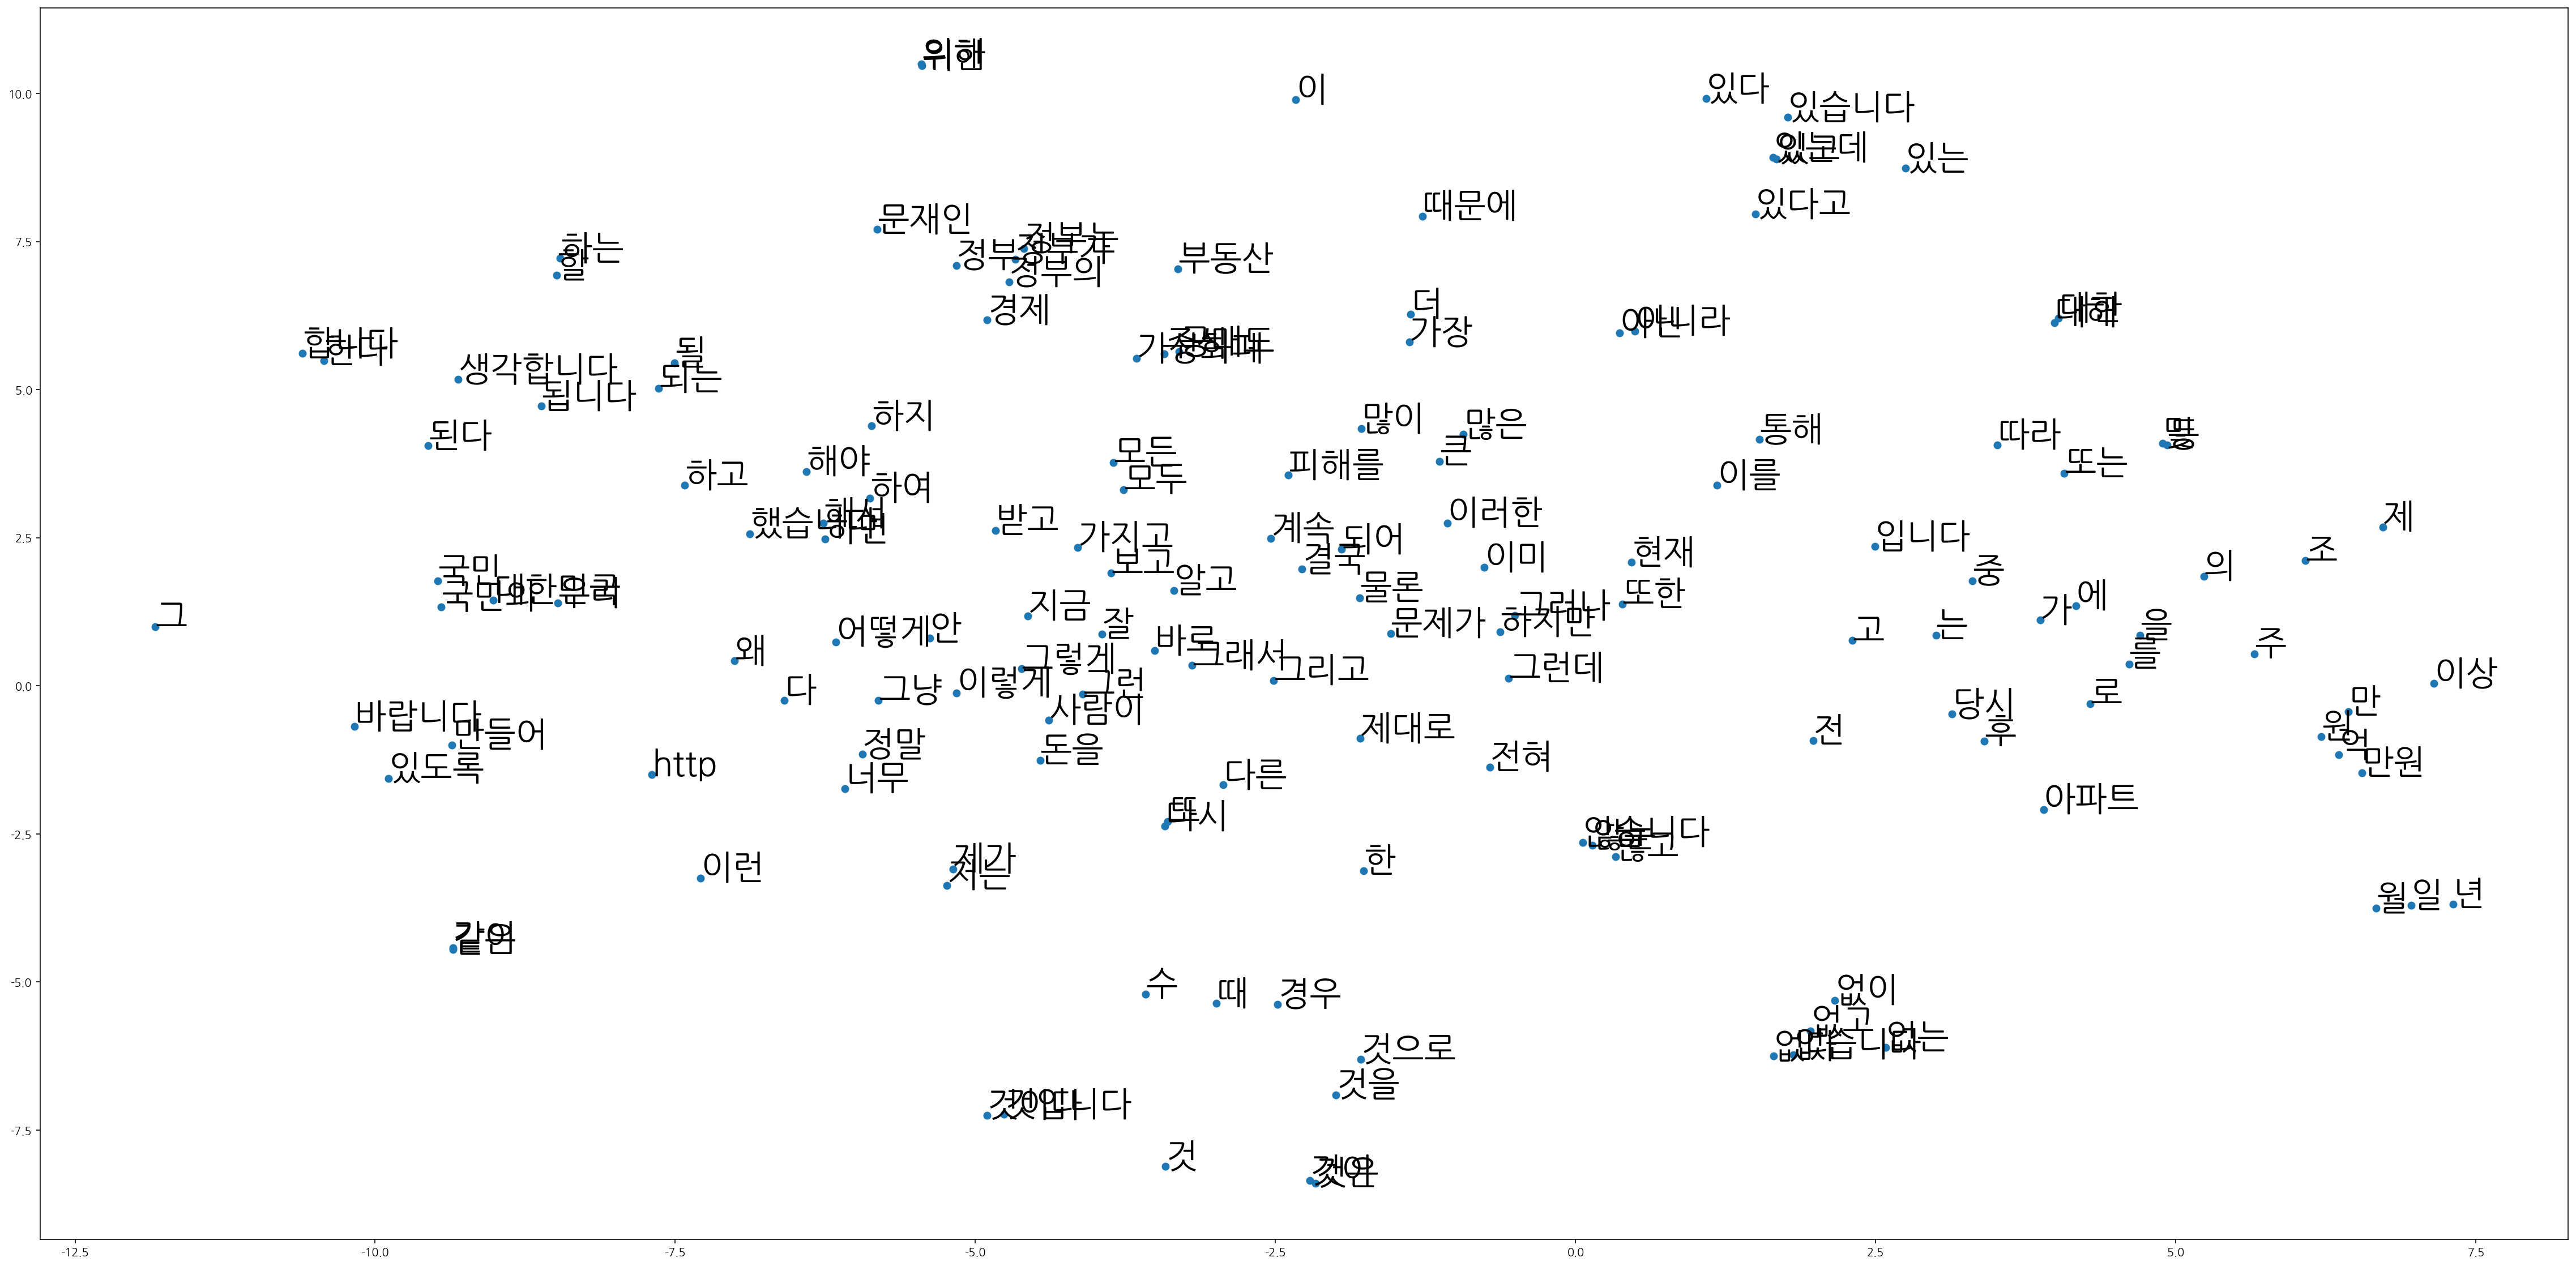

In [52]:
fig = plt.figure()
fig.set_size_inches(40, 20)
ax = fig.add_subplot(1, 1, 1)

ax.scatter(df['x'], df['y'])

for word, pos in df.iterrows():
    ax.annotate(word, pos, fontsize=30)
plt.show()